In [376]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sentencepiece as spm
import matplotlib.pyplot as plt
from tqdm import tqdm

In [377]:
import json

class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setattr__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [378]:
config = Config({
    "n_enc_vocab": len(vocab),
    "n_dec_vocab": len(vocab),
    "n_enc_seq": 256,
    "n_dec_seq": 256,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


In [379]:
device = torch.device('cuda:6')

In [380]:
vocab_file = "kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

In [381]:
lines = [
    "겨울은 추워요.",
    "감기 조심 하세요."
]

In [382]:
inputs = []

for line in lines:
    pieces = vocab.EncodeAsPieces(line)
    ids = vocab.EncodeAsIds(line)
    inputs.append(torch.tensor(ids))
    print(pieces)


['▁겨울', '은', '▁추', '워', '요', '.']
['▁감', '기', '▁조', '심', '▁하', '세', '요', '.']


In [383]:
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
print(inputs.size())


torch.Size([2, 8])


In [384]:
print(inputs)

tensor([[3207, 3578,  195, 3931, 3734, 3564,    0,    0],
        [ 201, 3580,   53, 3807,   27, 3657, 3734, 3564]])


In [385]:
n_vocab = len(vocab)
d_hidn = 256
nn_emb = nn.Embedding(n_vocab, d_hidn)

input_embs = nn_emb(inputs)

print(input_embs.size)

<built-in method size of Tensor object at 0x7fdba01a4c20>


In [386]:
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2*(i_hidn // 2) / d_hidn)
    
    def get_posi_angle_vec(positon):
        return [cal_angle(positon, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [387]:
n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

(64, 256)


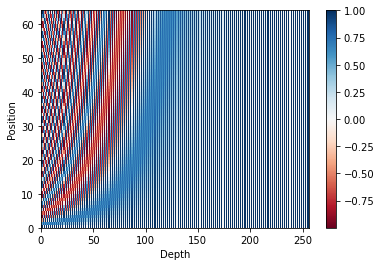

In [388]:
print (pos_encoding.shape) # 크기 출력
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [389]:
pos_encoding= torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

positions = torch.arange(inputs.size(1), device=inputs.device, dtype= inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() +1
pos_mask = inputs.eq(0)
positions.masked_fill_(pos_mask,0)
pos_embs = nn_pos(positions)

print(inputs)
print(positions)
print(pos_embs.size())

tensor([[3207, 3578,  195, 3931, 3734, 3564,    0,    0],
        [ 201, 3580,   53, 3807,   27, 3657, 3734, 3564]])
tensor([[1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])
torch.Size([2, 8, 256])


In [390]:
input_sums = input_embs + pos_embs

In [391]:
print(input_sums.size())

torch.Size([2, 8, 256])


In [392]:
Q = input_sums
K = input_sums
V = input_sums

attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0),Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask[0])

torch.Size([2, 8, 8])
tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True]])


In [393]:
K.size()

torch.Size([2, 8, 256])

In [394]:
scores = torch.matmul(Q,K.transpose(-1,-2))
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[423.0276, 128.3535, 145.4933,  82.5485,  87.5489,  93.3918,  96.1231,
          96.1231],
        [128.3535, 447.6760, 169.8183,  88.1307, 104.3250, 113.4511, 101.3444,
         101.3444],
        [145.4933, 169.8183, 411.6538, 125.8166, 133.3591, 115.6434, 100.0860,
         100.0860],
        [ 82.5485,  88.1307, 125.8166, 413.0880, 119.6898,  95.8693, 105.9346,
         105.9346],
        [ 87.5489, 104.3250, 133.3591, 119.6898, 370.7445,  98.4975, 117.4565,
         117.4565],
        [ 93.3918, 113.4511, 115.6434,  95.8693,  98.4975, 387.5286,  99.8463,
          99.8463],
        [ 96.1231, 101.3444, 100.0860, 105.9346, 117.4565,  99.8463, 373.3136,
         373.3136],
        [ 96.1231, 101.3444, 100.0860, 105.9346, 117.4565,  99.8463, 373.3136,
         373.3136]], grad_fn=<SelectBackward0>)


In [395]:
d_head = 64
scores = scores.mul_(1/np.sqrt(d_head))


In [396]:
scores.masked_fill_(attn_mask, -1e9)

tensor([[[ 5.2878e+01,  1.6044e+01,  1.8187e+01,  1.0319e+01,  1.0944e+01,
           1.1674e+01, -1.0000e+09, -1.0000e+09],
         [ 1.6044e+01,  5.5960e+01,  2.1227e+01,  1.1016e+01,  1.3041e+01,
           1.4181e+01, -1.0000e+09, -1.0000e+09],
         [ 1.8187e+01,  2.1227e+01,  5.1457e+01,  1.5727e+01,  1.6670e+01,
           1.4455e+01, -1.0000e+09, -1.0000e+09],
         [ 1.0319e+01,  1.1016e+01,  1.5727e+01,  5.1636e+01,  1.4961e+01,
           1.1984e+01, -1.0000e+09, -1.0000e+09],
         [ 1.0944e+01,  1.3041e+01,  1.6670e+01,  1.4961e+01,  4.6343e+01,
           1.2312e+01, -1.0000e+09, -1.0000e+09],
         [ 1.1674e+01,  1.4181e+01,  1.4455e+01,  1.1984e+01,  1.2312e+01,
           4.8441e+01, -1.0000e+09, -1.0000e+09],
         [ 1.2015e+01,  1.2668e+01,  1.2511e+01,  1.3242e+01,  1.4682e+01,
           1.2481e+01, -1.0000e+09, -1.0000e+09],
         [ 1.2015e+01,  1.2668e+01,  1.2511e+01,  1.3242e+01,  1.4682e+01,
           1.2481e+01, -1.0000e+09, -1.0000e+09]],

In [397]:
attn_prob = nn.Softmax(dim=-1)(scores)
print(attn_prob.size())
print(attn_prob[0])

torch.Size([2, 8, 8])
tensor([[1.0000e+00, 1.0071e-16, 8.5812e-16, 3.2846e-19, 6.1367e-19, 1.2739e-18,
         0.0000e+00, 0.0000e+00],
        [4.6238e-18, 1.0000e+00, 8.2412e-16, 3.0299e-20, 2.2939e-19, 7.1779e-19,
         0.0000e+00, 0.0000e+00],
        [3.5562e-15, 7.4391e-14, 1.0000e+00, 3.0395e-16, 7.8031e-16, 8.5219e-17,
         0.0000e+00, 0.0000e+00],
        [1.1378e-18, 2.2861e-18, 2.5407e-16, 1.0000e+00, 1.1813e-16, 6.0146e-18,
         0.0000e+00, 0.0000e+00],
        [4.2288e-16, 3.4430e-15, 1.2975e-13, 2.3499e-14, 1.0000e+00, 1.6618e-15,
         0.0000e+00, 0.0000e+00],
        [1.0771e-16, 1.3219e-15, 1.7387e-15, 1.4681e-16, 2.0390e-16, 1.0000e+00,
         0.0000e+00, 0.0000e+00],
        [4.1744e-02, 8.0176e-02, 6.8506e-02, 1.4231e-01, 6.0078e-01, 6.6484e-02,
         0.0000e+00, 0.0000e+00],
        [4.1744e-02, 8.0176e-02, 6.8506e-02, 1.4231e-01, 6.0078e-01, 6.6484e-02,
         0.0000e+00, 0.0000e+00]], grad_fn=<SelectBackward0>)


In [398]:
context = torch.matmul(attn_prob, V)

In [399]:
context.size()

torch.Size([2, 8, 256])

In [400]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.scale = 1 / (config.d_head ** 0.5)
        self.drop_out = nn.Dropout(config.dropout)
    
    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        attn_prob = nn.Softmax(dim=-1)(scores)
        attn_prob = self.drop_out(attn_prob)
        context = torch.matmul(attn_prob, V)
        return context, attn_prob

In [401]:
Q = input_sums
K = input_sums
V = input_sums

attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0),Q.size(1),K.size(1))

batch_size = Q.size(0)
n_head = 2

In [402]:
W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

q_s = W_Q(Q)
print(q_s.size())

torch.Size([2, 8, 128])


In [403]:
q_s = q_s.view(batch_size, -1, n_head, d_head)
print(q_s.size())

torch.Size([2, 8, 2, 64])


In [404]:
q_s = q_s.transpose(1,2)

In [405]:
q_s.size()

torch.Size([2, 2, 8, 64])

In [406]:
q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1,2)
k_s = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1,2)
v_s = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1,2)

In [407]:
print(q_s.size(), k_s.size(), v_s.size())

torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64])


In [408]:
print(attn_mask.size())

torch.Size([2, 8, 8])


In [409]:
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)

In [410]:
attn_mask.size()

torch.Size([2, 2, 8, 8])

In [411]:
scaled_dot_attn = ScaledDotProductAttention(config=config)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)

In [412]:
context.size()

torch.Size([2, 2, 8, 64])

In [413]:
attn_prob.size()

torch.Size([2, 2, 8, 8])

In [414]:
context = context.transpose(1,2).contiguous().view(batch_size, -1, n_head*d_head)

In [415]:
context.size()

torch.Size([2, 8, 128])

In [416]:
linear = nn.Linear(n_head*d_head, d_hidn)
output = linear(context)

In [417]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)

        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head*self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head*self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head*self.config.d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(config)
        self.linear = nn.Linear(self.config.n_head*self.config.d_head, self.config.d_hidn)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)

        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        
        attn_mask = attn_mask.unsqueeze(1).repeat(1,self.config.n_head,1,1)

        context, attn_prob = self.scaled_dot_attn(q_s,k_s,v_s, attn_mask)

        context = context.transpose(1,2).contiguous().view(batch_size, -1, self.config.n_head*self.config.d_head)
        output = self.linear(context)
        output = self.dropout(output)
        return output, attn_prob
    


In [418]:
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0),seq.size(1),seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1)
    return subsequent_mask

Q = input_sums
K = input_sums
V = input_sums

attn_pad_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0),Q.size(1),K.size(1))

print(attn_pad_mask[1])

attn_dec_mask = get_attn_decoder_mask(inputs)

print(attn_dec_mask[1])

attn_mask = torch.gt((attn_pad_mask + attn_dec_mask), 0)

tensor([[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]])
tensor([[0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]])


In [419]:
attention = MultiHeadAttention(config)

output, attn_prob = attention(Q,K,V, attn_mask)

print(output.size(), attn_prob.size())

torch.Size([2, 8, 256]) torch.Size([2, 4, 8, 8])


In [420]:
conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn*4, kernel_size=1)
ff_1 = conv1(output.transpose(1,2))
print(ff_1.size())

torch.Size([2, 1024, 8])


In [421]:
active = F.gelu
ff_2 = active(ff_1)

In [422]:
conv2 = nn.Conv1d(in_channels=d_hidn*4, out_channels=d_hidn, kernel_size=1)
ff_3 = conv2(ff_2).transpose(1,2)
ff_3.size()

torch.Size([2, 8, 256])

In [444]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels= self.config.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_ff, out_channels= self.config.d_hidn, kernel_size=1)
        self.active = F.gelu
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, inputs):
        output = self.conv1(inputs.transpose(1,2))
        output = self.active(output)
        output = self.conv2(output).transpose(1,2)
        output = self.dropout(output)
        return output

In [442]:
def get_attn_pad_mask(seq_q, seq_k, i_pad):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(i_pad)
    pad_attn_mask = pad_attn_mask.unsqueeze(1).expand(batch_size, len_q, len_k)
    return pad_attn_mask

In [425]:
class EncoderLayer(nn.Module):
      def __init__(self, config):
            super().__init__()
            self.config = config
            
            self.self_attn = MultiHeadAttention(self.config)
            self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps = self.config.layer_norm_epsilon)
            self.pos_ffn = PoswiseFeedForwardNet(self.config)
            self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps = self.config.layer_norm_epsilon)

      def forward(self, inputs, attn_mask):
            att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
            att_outputs = self.layer_norm1(att_outputs)
            ffn_outputs = self.pos_ffn(att_outputs)
            ffn_outputs = self.layer_norm2(ffn_outputs)

            return ffn_outputs, attn_prob

In [426]:
class Encoder(nn.Module):
      def __init__(self, config):
            super().__init__()
            self.config = config

            self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
            sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_enc_seq + 1, self.config.d_hidn))
            self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

            self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])

      def forward(self, inputs):
            positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0),inputs.size(1)).contiguous() + 1
            pos_mask = inputs.eq(self.config.i_pad)
            positions.masked_fill_(pos_mask, 0)

            outputs = self.enc_emb(inputs) + self.pos_emb(positions)

            attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)

            attn_probs = []

            for layer in self.layers:
                  outputs, attn_prob = layer(outputs, attn_mask)
                  attn_probs.append(attn_prob)

            return outputs, attn_probs

In [446]:
class DecoderLayer(nn.Module):
      def __init__(self, config):
            super().__init__()
            self.config = config
            self.self_attn = MultiHeadAttention(config = self.config)
            self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps = self.config.layer_norm_epsilon)
            self.dec_enc_attn = MultiHeadAttention(config = self.config)
            self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps = self.config.layer_norm_epsilon)
            self.pos_ffn = PoswiseFeedForwardNet(config = self.config)
            self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps = self.config.layer_norm_epsilon)
      
      def forward(self, dec_input, enc_output, self_attn_mask, dec_enc_attn_mask):
            self_att_outputs, self_attn_prob = self.self_attn(dec_input, dec_input, dec_input, self_attn_mask)
            self_att_outputs = self.layer_norm1(dec_input + self_att_outputs)
            dec_enc_attn_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_att_outputs, enc_output,enc_output, dec_enc_attn_mask)
            dec_enc_attn_outputs = self.layer_norm2(self_att_outputs + dec_enc_attn_outputs)

            ffn_outputs = self.pos_ffn(dec_enc_attn_outputs)
            ffn_outputs = self.layer_norm3(dec_enc_attn_outputs + ffn_outputs)

            return ffn_outputs, self_attn_prob, dec_enc_attn_prob

            

In [439]:
class Decoder(nn.Module):
      def __init__(self, config):
            super().__init__()
            self.config = config

            self.dec_embs = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
            sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
            self.pos_embs = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

            self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(config.n_layer)])

      def forward(self, dec_inputs, enc_inputs, enc_outputs):
            positions = torch.arange(dec_inputs.size(1),device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0),dec_inputs.size(1)).contiguous() + 1
            pos_mask = dec_inputs.eq(self.config.i_pad)
            positions.masked_fill_(pos_mask, 0)

            dec_outputs = self.dec_embs(dec_inputs) + self.pos_embs(positions)
            dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad)
            dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs)
            dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)
            dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, self.config.i_pad)

            self_attn_probs = []
            dec_enc_attn_probs = []
            for layer in self.layers:
                  dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
                  self_attn_probs.append(self_attn_prob)
                  dec_enc_attn_probs.append(dec_enc_attn_prob)
            
            return dec_outputs, self_attn_probs, dec_enc_attn_probs

In [429]:
class Transformer(nn.Module):
      def __init__(self,config):
            super().__init__()
            self.config = config

            self.encoder = Encoder(self.config)
            self.decoder = Decoder(self.config)

      def forward(self, enc_inputs, dec_inputs):
            enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs)
            dec_outputs, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_inputs, enc_inputs, enc_outputs)
      
            return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

In [430]:
class MovieClassification(nn.Module):
      def __init__(self, config):
            super().__init__()
            self.config = config

            self.transformer = Transformer(self.config)
            self.projection = nn.Linear(self.config.d_hidn, self.config.n_output, bias = False)
      
      def forward(self, enc_inputs, dec_inputs):
            dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs = self.transformer(enc_inputs, dec_inputs)
            dec_outputs, _ = torch.max(dec_outputs, dim = 1)

            logits = self.projection(dec_outputs)

            return logits, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs


In [431]:
class MovieDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.labels = []
        self.sentences = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc=f"Loading {infile}", unit=" lines")):
                data = json.loads(line)
                self.labels.append(data["label"])
                self.sentences.append([vocab.piece_to_id(p) for p in data["doc"]])
    
    def __len__(self):
        assert len(self.labels) == len(self.sentences)
        return len(self.labels)
    
    def __getitem__(self, item):
        return (torch.tensor(self.labels[item]),
                torch.tensor(self.sentences[item]),
                torch.tensor([self.vocab.piece_to_id("[BOS]")]))

In [432]:
def movie_collate_fn(inputs):
    labels, enc_inputs, dec_inputs = list(zip(*inputs))

    enc_inputs = torch.nn.utils.rnn.pad_sequence(enc_inputs, batch_first=True, padding_value=0)
    dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=0)

    batch = [
        torch.stack(labels, dim=0),
        enc_inputs,
        dec_inputs,
    ]
    return batch

In [433]:
batch_size = 128
train_dataset = MovieDataSet(vocab, "ratings_train.json")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=movie_collate_fn)
test_dataset = MovieDataSet(vocab, "ratings_test.json")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=movie_collate_fn)

Loading ratings_test.json: 100%|██████████| 49997/49997 [00:01<00:00, 44802.08 lines/s]


In [434]:
def eval_epoch(config, model, data_loader):
    matchs = []
    model.eval()

    n_word_total = 0
    n_correct_total = 0
    with tqdm(total=len(data_loader), desc=f"Valid") as pbar:
        for i, value in enumerate(data_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]
            _, indices = logits.max(1)

            match = torch.eq(indices, labels).detach()
            matchs.extend(match.cpu())
            accuracy = np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

            pbar.update(1)
            pbar.set_postfix_str(f"Acc: {accuracy:.3f}")
    return np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

In [435]:
def train_epoch(config, epoch, model, criterion, optimizer, train_loader):
    losses = []
    model.train()

    with tqdm(total=len(train_loader), desc=f"Train {epoch}") as pbar:
        for i, value in enumerate(train_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            optimizer.zero_grad()
            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]

            loss = criterion(logits, labels)
            loss_val = loss.item()
            losses.append(loss_val)

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

In [436]:
config.device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
config.n_output = 2
print(config)

learning_rate = 5e-5
n_epoch = 10

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


In [447]:
model = MovieClassification(config)
model.to(config.device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses, scores = [], []
for epoch in range(n_epoch):
    loss = train_epoch(config, epoch, model, criterion, optimizer, train_loader)
    score = eval_epoch(config, model, test_loader)

    losses.append(loss)
    scores.append(score)

Valid: 100%|██████████| 391/391 [02:14<00:00,  2.91it/s, Acc: 0.817]


In [448]:
from IPython.display import display

,loss,score
0,0.538287,0.781287
1,0.442725,0.795828
2,0.418623,0.804268
3,0.401902,0.806528
4,0.385819,0.803628
5,0.372617,0.815789
6,0.362798,0.812729
7,0.348736,0.819509
8,0.338230,0.817449
9,0.330414,0.817149


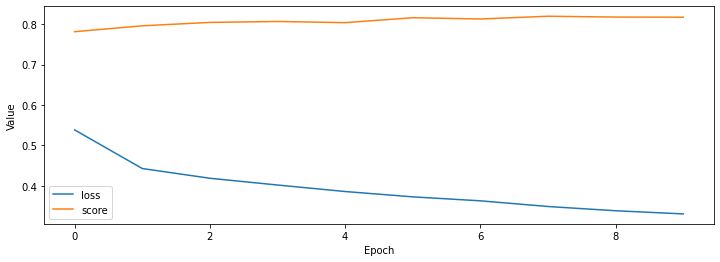

In [449]:
data = {
    "loss": losses,
    "score": scores
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.plot(scores, label="score")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()